In [ ]:
!pip install osmnx

In [2]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

In [4]:
#Obtenção do grafo da cidade de Natal
place = "Natal, Rio Grande do Norte, Brazil"
G = ox.graph_from_place(place, network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

In [42]:
#Escolha dos pontos de interesse
tags = {
    'tourism': 'hotel',
    'aeroway': 'aerodrome'
}

pois = ox.features.features_from_place(place, tags=tags)

#Dividir os POIs em categorias
poi_categories = {
    'hotel': {'color': 'orange', 'points': [], 'label': 'Hotel'},
    'aerodrome': {'color': 'purple', 'points': [], 'label': 'Aeroporto'}
}


# Extrair pontos e classificar por categoria
poi_points = []
for idx, row in pois.iterrows():
    if row.get('tourism') == 'hotel':
        category = 'hotel'
    elif row.get('aeroway') == 'aerodrome':
        category = 'aerodrome'
    else:
        continue  # ignora se não pertence a nenhuma categoria

    # Extrair coordenadas
    if row.geometry.geom_type == 'Point':
        point = (row.geometry.y, row.geometry.x)
    else:
        point = (row.geometry.centroid.y, row.geometry.centroid.x)

    poi_points.append(point)
    poi_categories[category]['points'].append(point)


In [43]:
#Encontrar os nós mais proximos dos POIs
latitudes = [pt[0] for pt in poi_points]
longitudes = [pt[1] for pt in poi_points]
poi_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
poi_nodes = list(set(poi_nodes))

if len(poi_nodes) < 2:
    raise ValueError("POIs insuficientes para criar um MST (menos de 2 pontos).")

In [44]:
len(poi_points) #quantidade de POIs encontrados

93

In [45]:
#Construir o grafo completo com a menor rota entre os POIs
G_interest = nx.Graph()
for i in range(len(poi_nodes)):
    for j in range(i+1, len(poi_nodes)):
        route = nx.shortest_path(G_undirected, poi_nodes[i], poi_nodes[j], weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(poi_nodes[i], poi_nodes[j], weight=route_length)

In [46]:
#Calculo do MST
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST entre os POIs selecionados:", total_mst_length, "metros")

Comprimento total do MST entre os POIs selecionados: 48066.88804554464 metros


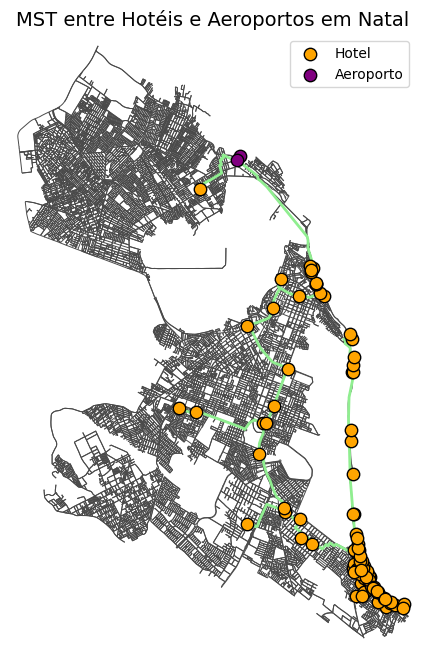

In [47]:
#Plot do gráfico final

mst_routes = []
for (u, v, d) in mst_edges:
    route = nx.shortest_path(G_undirected, u, v, weight='length')
    mst_routes.append(route)

# Plotar o grafo base
fig, ax = ox.plot_graph(
    G_undirected, node_size=0, edge_color="#4a4a4a", edge_linewidth=0.7, bgcolor="white", show=False, close=False
)

# Destacar as rotas do MST
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='lightgreen', linewidth=2, zorder=4, label='MST' if i == 0 else "")

# Plotar cada categoria de POI com uma cor diferente
for cat, data in poi_categories.items():
    if data['points']:
        xs = [pt[1] for pt in data['points']]
        ys = [pt[0] for pt in data['points']]
        ax.scatter(xs, ys, c=data['color'], s=80, zorder=5, label=data['label'], edgecolor='black')

plt.legend(loc='upper right', fontsize=10, frameon=True, facecolor='white') #Legenda do gráfico
plt.title("MST entre Hotéis e Aeroportos em Natal", fontsize=14)
plt.show()